In [1]:
from os import chdir
chdir('..')

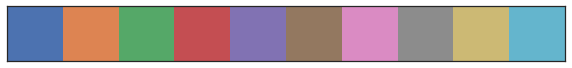

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import math
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale
from os import path
from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly, load_polygon, get_max_bounds_polys
%matplotlib inline
sns.set(font_scale=2)  # crazy big
sns.set_style("white")
current_palette = sns.color_palette()
sns.palplot(current_palette)


In [3]:
def simple(xmin, ymin, xmax, ymax):
    return [xmin, xmax], [ymin, ymax]


def scale_axes_poly_(points):
    maxs = points.max(axis=0)
    mins = points.min(axis=0)
    return [mins[0], maxs[0]], [mins[1], maxs[1]]

def plot_gt(poly):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plot_poly(poly, ax, plot_holes=True)
    scale_axes(*simple(*get_max_bounds_polys([miholes])), ax)
    plt.axis('off')
    ax.axis('equal')
    return fig

In [4]:
num_points = 2000
FIXTURES = "test_fixtures"
GEN_POLYS_FILE = path.join(FIXTURES,"generated", "polygons.pkl")

gen_polys, poly_params = pickle.load(open(GEN_POLYS_FILE, 'rb'))
df = pd.DataFrame.from_records(poly_params)
df.head()

,nv,pr,pi,ps,r,convexity
0,100,100,0.1,0.1,0,0.815492
1,100,100,0.1,0.1,1,0.799573
2,100,100,0.1,0.1,2,0.814719
3,100,100,0.1,0.1,3,0.817231
4,100,100,0.1,0.1,4,0.762802


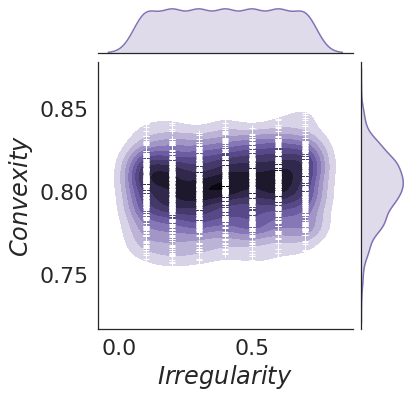

In [5]:
df_pi = df[df.ps == 0.1]
g = sns.jointplot(x="pi", y="convexity", data=df_pi, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Irregularity$", "$Convexity$");

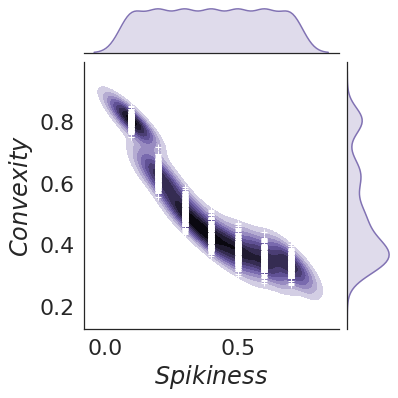

In [6]:
df_ps = df[df.pi == 0.1]
g = sns.jointplot(x="ps", y="convexity", data=df_ps, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Spikiness$", "$Convexity$");

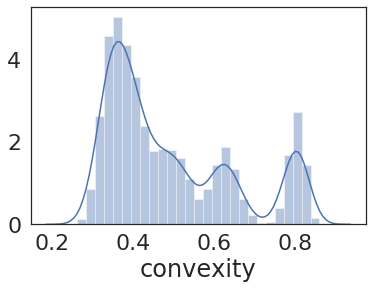

In [7]:
sns.distplot(df['convexity'])

# Polylidar Accuracy and Timings

         alg  shape  points   l2_norm   time  holes section  convexity
0  polylidar      0    2000  0.070596  1.131  False     all   0.815492
1  polylidar      1    2000  0.074861  1.089  False     all   0.799573
2  polylidar      2    2000  0.080359  1.093  False     all   0.814719
3  polylidar      3    2000  0.078682  1.209  False     all   0.817231
4  polylidar      4    2000  0.086809  1.075  False     all   0.762802
0.25353468475468144


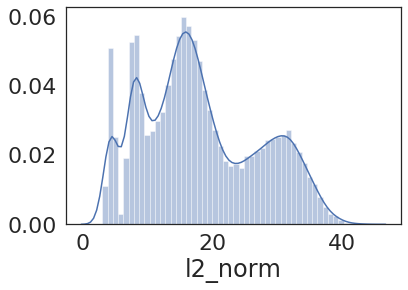

In [8]:
df = pd.read_csv(path.join(FIXTURES, "results", "polylidar_montecarlo.csv"))
print(df.head())
df['l2_norm'] = df['l2_norm'] * 100
sns.distplot(df['l2_norm'])
print(df['convexity'].min())

In [9]:
# These numbers are chosen arbitrarily
# Looking at the distribuiton I generated way to many complex polygons
# convexity_vh = 0.75
convexity_hi = 0.75
convexity_mid = 0.55
def get_catergory(x):
#     if x >= convexity_vh:
#         return 'very hi'
    if x >= convexity_hi:
        return "hi"
    elif x >= convexity_mid:
        return "mid"
    return "low"

df['$C$'] = df['convexity'].map(get_catergory)
df_result = df.groupby(['$C$', 'points']).agg(
    {'l2_norm':['mean','std', 'max'],'time':['mean', 'std', 'max']})
df_result= df_result.rename(columns={"l2_norm": "$L^2\%$", "time": "time (ms)"})
df_result = df_result.reindex(['very hi','hi', 'mid', 'low'], level='$C$')
print(df_result.to_latex(escape=False, float_format="%.1f"))
df_result

\begin{tabular}{llrrrrrr}
\toprule
    &      & \multicolumn{3}{l}{$L^2\%$} & \multicolumn{3}{l}{time (ms)} \\
    &      &    mean & std &  max &      mean & std & max \\
$C$ & points &         &     &      &           &     &     \\
\midrule
hi & 2000 &     8.4 & 1.0 & 11.6 &       1.1 & 0.0 & 1.5 \\
    & 8000 &     4.4 & 0.5 &  6.1 &       4.6 & 0.1 & 5.0 \\
mid & 2000 &    15.1 & 2.0 & 23.7 &       1.1 & 0.0 & 1.7 \\
    & 8000 &     8.0 & 1.1 & 13.0 &       4.6 & 0.1 & 8.1 \\
low & 2000 &    28.3 & 5.1 & 43.6 &       1.1 & 0.0 & 1.3 \\
    & 8000 &    15.5 & 3.0 & 25.0 &       4.7 & 0.2 & 9.9 \\
\bottomrule
\end{tabular}



$L^2\%$                      time (ms)                 
                 mean       std        max      mean       std    max
$C$ points                                                           
hi  2000     8.381954  0.969930  11.635447  1.064841  0.025623  1.539
    8000     4.412594  0.456623   6.104199  4.637857  0.105905  5.040
mid 2000    15.090616  2.034100  23.746601  1.068336  0.017656  1.674
    8000     7.998701  1.096111  13.035503  4.643335  0.122219  8.102
low 2000    28.324677  5.095368  43.558420  1.079560  0.013442  1.326
    8000    15.503937  2.960977  25.037691  4.686473  0.150019  9.932

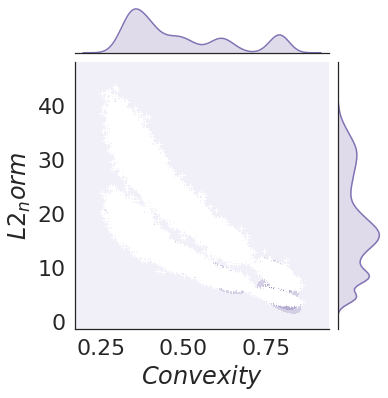

In [10]:
g = sns.jointplot(x="convexity", y="l2_norm", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Convexity$", "$L2_norm$");

# Visualize Generated Polygons

In [11]:
polygon_fpath = "test_fixtures/generated/polygons_holes.pkl"
poly_list, poly_params = pickle.load(open(polygon_fpath, 'rb'))
df = pd.DataFrame.from_records(poly_params)
lc_index = df[df.convexity == df['convexity'].min()].index.values[0]
lc_convexity = df[df.convexity == df['convexity'].min()].values[0][0]
vh_index = df[df.convexity == df['convexity'].max()].index.values[0]
vh_convexity = df[df.convexity == df['convexity'].max()].values[0][0]

lc_poly = poly_list[lc_index]
vh_holy = poly_list[vh_index]

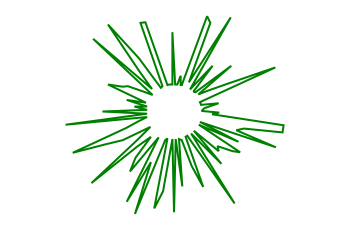

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_poly(lc_poly, ax, plot_holes=False)
scale_axes(*simple(*get_max_bounds_polys([lc_poly])), ax)
plt.axis('off')
ax.axis('equal')
fig.savefig("./assets/pics/low_convexity.pdf",bbox_inches='tight')

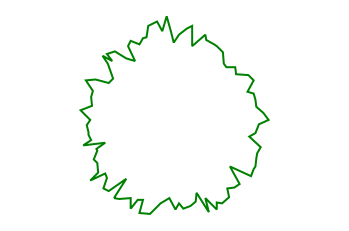

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_poly(vh_holy, ax, plot_holes=False)
scale_axes(*simple(*get_max_bounds_polys([vh_holy])), ax)
plt.axis('off')
ax.axis('equal')
fig.savefig("./assets/pics/hi_convexity.pdf",bbox_inches='tight')

In [14]:
print(f"LC Poly: {lc_convexity*100:.1f}; HC Poly: {vh_convexity*100:.1f}")

LC Poly: 10000.0; HC Poly: 10000.0
